In [1]:
import os
files = os.listdir('../../pythia/results/bias-evals/')

In [2]:
import json
def read_file(f):
    with open('../../pythia/results/bias-evals/' + f, 'r') as f:
        return json.load(f)

In [3]:
def parse_json(f):
    data = read_file(f)
    # get all values where key contains 'english' in a new dict 
    english = {k: v for k, v in data['results'].items() if 'english' in k}
    # get only the pct_stereotype key from the new dict
    english = {k: v['pct_stereotype'] for k, v in english.items()}
    return english

In [4]:
parse_json(r'pythia-1.3b-deduped-step69000_eval_results_01-22-2023-09-20-33.json')

{'crows_pairs_english_gender': 0.61875,
 'crows_pairs_english': 0.6118067978533095}

In [5]:
pythia_files = []
intervened_files = []
long_intervened_files = []
for f in files:
  if f.startswith('pythia'):
    pythia_files.append(f)
  elif f.startswith('intervention'):
    intervened_files.append(f)
  elif f.startswith('long-intervention'):
    long_intervened_files.append(f)

In [6]:
pythia_res = {}
intervened_res = {}
long_intervened_res = {}

In [7]:
sizes_pythia = []
for f in pythia_files:
    split_name = f.split('-')
    sizes_pythia.append(split_name[1])
sizes_pythia = list(set(sizes_pythia))

steps_pythia = []
for f in pythia_files:
    split_name = f.split('-')
    if split_name[1] == '350m':
        if split_name[2] != 'deduped':
            continue
    if split_name[1] == '6.9b':
        steps_pythia.append(int(split_name[2].split('_')[0][4:]))
        continue
    steps_pythia.append(int(split_name[3].split('_')[0][4:]))
steps_pythia = list(set(steps_pythia))

sizes_intervened = []
for f in intervened_files:
    split_name = f.split('-')
    sizes_intervened.append(split_name[1])
sizes_intervened = list(set(sizes_intervened))

steps_intervened = []
for f in intervened_files:
    split_name = f.split('-')
    if split_name[1] == '6.9b':
        steps_intervened.append(int(split_name[2].split('_')[0][4:]))
        continue
    steps_intervened.append(int(split_name[3].split('_')[0][4:]))
steps_intervened = list(set(steps_intervened))

sizes_long_intervened = []
for f in long_intervened_files:
    split_name = f.split('-')
    sizes_long_intervened.append(split_name[2])
sizes_long_intervened = list(set(sizes_long_intervened))

steps_long_intervened = []
for f in long_intervened_files:
    split_name = f.split('-')
    step = int(split_name[4].split('_')[0][4:])
    steps_long_intervened.append(step)
steps_long_intervened = list(set(steps_long_intervened))

In [8]:
task_names = ['crows_pairs_english_gender']

In [9]:
sizes_pythia

['1.3b', '6.9b', '19m', '350m']

In [10]:
pythia_files[0].split('-')

['pythia',
 '1.3b',
 'deduped',
 'step11500_eval_results_01',
 '20',
 '2023',
 '14',
 '41',
 '42.json']

In [11]:
for sizes in sizes_pythia:
    for f in pythia_files:
        file_split = f.split('-')
        if file_split[1] == '350m':
            if file_split[2] != 'deduped':
                continue
        if file_split[1] == '6.9b':
            step = int(file_split[2].split('_')[0][4:])
        else:
            step = int(file_split[3].split('_')[0][4:])
        if file_split[1] == sizes:
            pythia_res[(sizes, step)] = parse_json(f)

In [12]:
for sizes in sizes_intervened:
    for f in intervened_files:
        file_split = f.split('-')
        if file_split[1] == '6.9b':
            step = int(file_split[2].split('_')[0][4:])
        else:
            step = int(file_split[3].split('_')[0][4:])
        if file_split[1] == sizes:
            intervened_res[(sizes, step)] = parse_json(f)

In [13]:
for sizes in sizes_long_intervened:
    for f in long_intervened_files:
        file_split = f.split('-')
        step = int(file_split[4].split('_')[0][4:])
        if file_split[2] == sizes:
            long_intervened_res[(sizes, step)] = parse_json(f)

In [51]:
# Plot the results
import matplotlib.pyplot as plt
import numpy as np

def plot_results(pythia_dict, intervened_dict, task_name, model_size, save_name, connect=True):
    ls_pythia = []
    ls_intervened = []
    # plot pythia
    for key in pythia_dict:
        if key[0] == model_size:
            ls_pythia.append((key[1], pythia_dict[key][task_name]))
    # Sort by step
    ls_pythia = sorted(ls_pythia, key=lambda x: x[0])
    # normalize x[0] to 1 to 100 %
    max_step = ls_pythia[-1][0]
    ls_pythia = [(x[0]/max_step*100, x[1]) for x in ls_pythia] 
    # plot intervened
    for key in intervened_dict:
        if key[0] == model_size:
            ls_intervened.append((key[1], intervened_dict[key][task_name]))
    # Sort by step
    ls_intervened = sorted(ls_intervened, key=lambda x: x[0])
    # normalize x[0] to 1 to 100 %
    max_step = ls_intervened[-1][0]
    ls_intervened = [(x[0]/max_step*100, x[1]) for x in ls_intervened]
    # Find first step where intervened matches pythia in x[0]
    c = 0
    for i in range(len(ls_pythia)):
        if ls_pythia[i][0] >= ls_intervened[0][0]:
            c = i
            break
    c -= 1
    if connect:
        # Add the point at index c to the beginning of ls_intervened
        # print('Adding point', ls_pythia[c], 'to ls_intervened')
        ls_intervened = [ls_pythia[c]] + ls_intervened
    # plot
    # increase figure size
    plt.rcParams["figure.figsize"] = (15, 10)
    plt.plot([x[0] for x in ls_pythia], [x[1] for x in ls_pythia], label=f'Pythia_{model_size}')
    # dotted line for intervened
    plt.plot([x[0] for x in ls_intervened], [x[1] for x in ls_intervened], label=f'Intervened_{model_size}', linestyle='dashed')
    plt.xlabel('% of Training')
    plt.ylabel('Pct stereotype')
    # plt.title('Pct stereotype for ' + task_name + ' for model size ' + model_size)
    # legend in top left
    plt.legend(loc='upper left')
    # plt.show()
    plt.savefig(save_name)

In [92]:
def plot_results_with_both_interventions(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_size, save_name, connect=True, normalize=False):
    ls_pythia = []
    ls_intervention = []
    ls_long_intervention = []
    # plot pythia
    for key in pythia_dict:
        if key[0] == model_size:
            ls_pythia.append((key[1], pythia_dict[key][task_name]))
    # Sort by step
    ls_pythia = sorted(ls_pythia, key=lambda x: x[0])
    # normalize x[0] to 1 to 100 %
    if normalize:
        max_step = ls_pythia[-1][0]
        ls_pythia = [(x[0]/max_step*100, x[1]) for x in ls_pythia]
    # plot intervention
    for key in intervention_dict:
        if key[0] == model_size:
            ls_intervention.append((key[1], intervention_dict[key][task_name]))
    # Sort by step
    ls_intervention = sorted(ls_intervention, key=lambda x: x[0])
    # normalize x[0] to 1 to 100 %
    if normalize:
        max_step = ls_intervention[-1][0]
        ls_intervention = [(x[0]/max_step*100, x[1]) for x in ls_intervention]
    # plot long intervention
    if long_intervention_dict is not None:
        for key in long_intervention_dict:
            if key[0] == model_size:
                ls_long_intervention.append((key[1], long_intervention_dict[key][task_name]))
        # Sort by step
        ls_long_intervention = sorted(ls_long_intervention, key=lambda x: x[0])
        # normalize x[0] to 1 to 100 %
        if normalize:
            max_step = ls_long_intervention[-1][0]
            ls_long_intervention = [(x[0]/max_step*100, x[1]) for x in ls_long_intervention]
    # Find first step where intervened matches pythia in x[0]
    c1 = 0
    for i in range(len(ls_pythia)):
        if ls_pythia[i][0] >= ls_intervention[0][0]:
            c1 = i
            break
    c1 -= 1

    c2 = 0
    if long_intervention_dict is not None:
        for i in range(len(ls_pythia)):
            if ls_pythia[i][0] >= ls_long_intervention[0][0]:
                c2 = i
                break
    c2 -= 1
    if connect:
        # Add the point at index c to the beginning of ls_intervened
        # print('Adding point', ls_pythia[c], 'to ls_intervened')
        ls_intervention = [ls_pythia[c1]] + ls_intervention
        if long_intervention_dict is not None:
            ls_long_intervention = [ls_pythia[c2]] + ls_long_intervention

    # Find step in pythia key[0] which is smaller than the first step in intervened and first step in long intervened
    point = min(ls_intervention[0][0], ls_long_intervention[0][0])
    c = 0
    for i in range(len(ls_pythia)):
        if ls_pythia[i][0] >= point:
            c = i
            break
    
    # plot
    plt.plot([x[0] for x in ls_pythia], [x[1] for x in ls_pythia], label=f'Pythia_{model_size}')
    plt.plot([x[0] for x in ls_intervention], [x[1] for x in ls_intervention], label=f'Intervention_{model_size}', linestyle='dashed')
    if long_intervention_dict is not None:
        plt.plot([x[0] for x in ls_long_intervention], [x[1] for x in ls_long_intervention], label=f'Long Intervention_{model_size}', linestyle='dashdot')
    plt.xlabel('% of Training')
    plt.ylabel('Pct stereotype')
    # plt.title('Pct stereotype for ' + task_name + ' for model size ' + model_size)
    plt.legend()
    # plt.show()
    # Save the plot
    plt.savefig(save_name)

In [85]:
sizes_pythia = ['19m', '350m', '1.3b', '6.9b']

In [88]:
# # Make all plots
# for task in task_names:
#     for size in sizes_pythia:
#         print('Plotting', task, size)
#         plot_results(pythia_res, intervened_res, task, size, 'memorization_plots/' + task + '_' + size + '_intervened.png')

# for task in task_names:
#     for size in sizes_long_intervened:
#         print('Plotting', task, size)
#         plot_results_with_both_interventions(pythia_res, intervened_res, long_intervened_res, task, size,
#                                                 'memorization_plots/' + task + '_' + size + '_long_intervened.png')

In [89]:
# for task in task_names:
#     for size in sizes_long_intervened:
#         print('Plotting', task, size)
#         plot_results_with_both_interventions(pythia_res, intervened_res, long_intervened_res, task, size,
#                                                 'memorization_plots/' + task + '_' + size + '_long_intervened.png')

In [90]:
sizes_long_intervened

['1.3b']

Plotting crows_pairs_english_gender 19m
Plotting crows_pairs_english_gender 350m
Plotting crows_pairs_english_gender 1.3b
Plotting crows_pairs_english_gender 6.9b


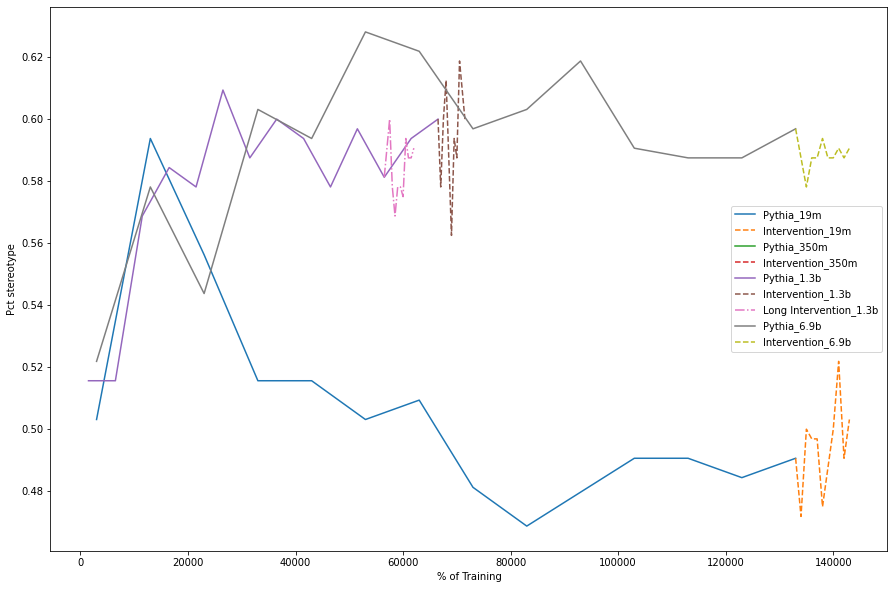

In [91]:
for task in task_names:
    for size in sizes_pythia:
        print('Plotting', task, size)
        long = None
        if size == '1.3b':
            long = long_intervened_res
        plot_results_with_both_interventions(pythia_res, intervened_res, long, task, size,
                                                'memorization_plots/' + task + '_' + size + '_long_intervened.png')

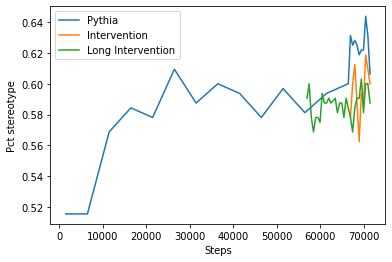

In [68]:
for task in task_names:
    for size in sizes_long_intervened:
        plot_results_with_both_interventions(pythia_res, intervened_res, long_intervened_res, task, size,
                                                'memorization_plots/' + task + '_' + size + '_long_intervened.png', False)

In [ ]:
# Plot the results
import matplotlib.pyplot as plt
import numpy as np

def plot_results(pythia_dict, intervened_dict, task_name, model_size, save_name, connect=True):
    ls_pythia = []
    ls_intervened = []
    # plot pythia
    for key in pythia_dict:
        if key[0] == model_size:
            ls_pythia.append((key[1], pythia_dict[key][task_name]))
    # Sort by step
    ls_pythia = sorted(ls_pythia, key=lambda x: x[0])
    # normalize x[0] to 1 to 100 %
    max_step = ls_pythia[-1][0]
    ls_pythia = [(x[0]/max_step*100, x[1]) for x in ls_pythia] 
    # plot intervened
    for key in intervened_dict:
        if key[0] == model_size:
            ls_intervened.append((key[1], intervened_dict[key][task_name]))
    # Sort by step
    ls_intervened = sorted(ls_intervened, key=lambda x: x[0])
    # normalize x[0] to 1 to 100 %
    max_step = ls_intervened[-1][0]
    ls_intervened = [(x[0]/max_step*100, x[1]) for x in ls_intervened]
    # Find first step where intervened matches pythia in x[0]
    c = 0
    for i in range(len(ls_pythia)):
        if ls_pythia[i][0] >= ls_intervened[0][0]:
            c = i
            break
    c -= 1
    if connect:
        # Add the point at index c to the beginning of ls_intervened
        # print('Adding point', ls_pythia[c], 'to ls_intervened')
        ls_intervened = [ls_pythia[c]] + ls_intervened
    # plot
    # increase figure size
    plt.rcParams["figure.figsize"] = (15, 10)
    plt.plot([x[0] for x in ls_pythia], [x[1] for x in ls_pythia], label=f'Pythia_{model_size}')
    # dotted line for intervened
    plt.plot([x[0] for x in ls_intervened], [x[1] for x in ls_intervened], label=f'Intervened_{model_size}', linestyle='dashed')
    plt.xlabel('% of Training')
    plt.ylabel('Pct stereotype')
    # plt.title('Pct stereotype for ' + task_name + ' for model size ' + model_size)
    # legend in top left
    plt.legend(loc='upper left')
    # plt.show()
    plt.savefig(save_name)